# Comparing ALCS Latent-Learning capabilities

Approach to compare *latent-learning* capabilities of various ALCS systems.

The following aspects will be compared:

- ability learn consequences of performing action in certain states (build accurate internal model of the environment),
- ability to generalize,
- size of internal classifier population,
- relative operation time

In [1]:
import os
import pathlib
import dill

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from pylab import cm

import gym

from lcs import Perception
from lcs.agents import EnvironmentAdapter

# Logger
# import logging
# logging.basicConfig(level=logging.DEBUG)

# Common plot settings
mpl.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

# Common color palette
palette = cm.get_cmap('Paired', 4)

COLORS = {
    'acs': palette(0),
    'acs2': palette(1),
    'acs2_ga': palette(2),
    'yacs': palette(3),
}

In [2]:
cache_prefix = f'{pathlib.Path().absolute()}/cache/'
cache_prefix

'/home/arc/Projects/pwr/pyalcs-experiments/alcs_comparison/cache/'

### Agents

In [3]:
import lcs.agents.acs as acs
import lcs.agents.acs2 as acs2
import lcs.agents.yacs as yacs

def run_acs(env, classifier_length, possible_actions, environment_adapter, metrics_trial_freq, metrics_fcn, explore_trials):
    cfg = acs.Configuration(classifier_length, possible_actions,
                            environment_adapter=environment_adapter,
                            metrics_trial_frequency=metrics_trial_freq,
                            user_metrics_collector_fcn=metrics_fcn)
    agent = acs.ACS(cfg)
    pop, metrics = agent.explore(env, explore_trials)
    
    return pop, metrics

def run_acs2(env, classifier_length, possible_actions, environment_adapter, metrics_trial_freq, metrics_fcn, explore_trials, do_ga):
    cfg = acs2.Configuration(classifier_length, possible_actions,
                             environment_adapter=environment_adapter,
                             do_ga=do_ga,
                             metrics_trial_frequency=metrics_trial_freq,
                             user_metrics_collector_fcn=metrics_fcn)
    agent = acs2.ACS2(cfg)
    pop, metrics = agent.explore(env, explore_trials)
    return pop, metrics

def run_yacs(env, classifier_length, possible_actions, environment_adapter, metrics_trial_freq, metrics_fcn, explore_trials, trace_length, feature_possible_values):
    cfg = yacs.Configuration(classifier_length, possible_actions,
                             environment_adapter=environment_adapter,
                             trace_length=trace_length,
                             feature_possible_values=feature_possible_values,
                             metrics_trial_frequency=metrics_trial_freq,
                             user_metrics_collector_fcn=metrics_fcn)
    agent = yacs.YACS(cfg)
    pop, metrics = agent.explore(env, explore_trials)
    return pop, metrics

### Helper functions

In [4]:
# convert collected metrics into pandas dataframe
def parse_metrics(agent, metrics):
    data = [[agent, d['perf_time'], d['trial'], d['knowledge'], d['pop'], d['generalization']] for d in metrics]

    df = pd.DataFrame(
        data,
        columns=['agent', 'time', 'trial', 'knowledge', 'population', 'generalization'])

    return df

In [5]:
# Compute proportion of wildcards in classifier condition across all classifiers
def generalization_score(pop):
    wildcards = sum(1 for cl in pop for cond in cl.condition if cond == '#' or (hasattr(cond, 'symbol') and cond.symbol == '#'))
    all_symbols = sum(len(cl.condition) for cl in pop)
    return wildcards / all_symbols

In [6]:
# Run single experiments using 4 algorithms. Return all population of classifiers and metrics
def run_experiment(common_params, acs_params={}, acs2_params={}, yacs_params={}):
    pop_acs, metrics_acs = run_acs(**{**common_params, **acs_params})
    pop_acs2, metrics_acs2 = run_acs2(do_ga=False, **{**common_params, **acs2_params})
    pop_acs2ga, metrics_acs2ga = run_acs2(do_ga=True, **{**common_params, **acs2_params})
    pop_yacs, metrics_yacs = run_yacs(**{**common_params, **yacs_params})
    
    metrics_df = pd.concat([
        parse_metrics('acs', metrics_acs),
        parse_metrics('acs2', metrics_acs2),
        parse_metrics('acs2_ga', metrics_acs2ga),
        parse_metrics('yacs', metrics_yacs),
    ])
    metrics_df.set_index(['agent', 'trial'], inplace=True)
    
    return {
        'acs': pop_acs,
        'acs2': pop_acs2,
        'acs2_ga': pop_acs2ga,
        'yacs': pop_yacs
    }, metrics_df

In [7]:
# Execute multiple experiments and average metrics
def avg_experiments(func, n=1):
    dfs = []
    for i in range(n):
        print(f'Executing {i} experiment')
        _, metrics_df = func()
        dfs.append(metrics_df)
    
    return pd.concat(dfs).groupby(['agent', 'trial']).mean()

In [8]:
# Cache function result into file (no-need for recomputation)
def get_from_cache_or_run(cache_path, fun):
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)

    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            return dill.load(f)
    else:
        res = fun()

        # save the results to file
        with open(cache_path, 'wb') as f:
            dill.dump(res, f)

        return res

In [9]:
def plot_comparison(metrics):   
    fig, axs = plt.subplots(2, 2, figsize=(22, 16))

    # Population
    axs[0, 0].set_title('Population size')
    metrics.loc['acs']['population'].plot(label='ACS', ax=axs[0, 0])
    metrics.loc['acs2']['population'].plot(label='ACS2', ax=axs[0, 0])
    metrics.loc['acs2_ga']['population'].plot(label='ACS2_GA', ax=axs[0, 0])
    metrics.loc['yacs']['population'].plot(label='YACS', ax=axs[0, 0])
    axs[0, 0].legend(loc='best', frameon=False)

    # Knowledge
    axs[0, 1].set_title('Knowledge')
    metrics.loc['acs']['knowledge'].plot(label='ACS', ax=axs[0, 1])
    metrics.loc['acs2']['knowledge'].plot(label='ACS2', ax=axs[0, 1])
    metrics.loc['acs2_ga']['knowledge'].plot(label='ACS2_GA', ax=axs[0, 1])
    metrics.loc['yacs']['knowledge'].plot(label='YACS', ax=axs[0, 1])
    axs[0, 1].legend(loc='lower right', frameon=False)

    # Generalization
    axs[1, 0].set_title('Generalization')
    metrics.loc['acs']['generalization'].plot(label='ACS', ax=axs[1, 0])
    metrics.loc['acs2']['generalization'].plot(label='ACS2', ax=axs[1, 0])
    metrics.loc['acs2_ga']['generalization'].plot(label='ACS2_GA', ax=axs[1, 0])
    metrics.loc['yacs']['generalization'].plot(label='YACS', ax=axs[1, 0])
    axs[1, 0].legend(loc='best', frameon=False)

    # Trial time
    metrics.groupby('agent')['time'].mean().plot.bar(ax=axs[1, 1])
    axs[1, 1].set_title('Average trial time')
    axs[1, 1].set_ylabel('Seconds [s]')
    axs[1, 1].set_xlabel('Agent')

# Environments
This section presents the multi-step environments that were used in experiments.

1. [Simple Maze](#Simple-Maze) - Simpler maze variant with limited perception and available actions

Discretized real-valued.

2. [Corridor](#Corridor) - one dimension and two actions are available. The agent is checked is optimal number of classifiers is created
3. [Grid](#Grid) - two dimensions and four actions.

Maybe (todo)

4. Maze4 / Maze6 - More advanced mazes (bigger perception and available actions)

## Simple Maze
In each trial the agent is placed in **S** tile. It can perceive 4 values (N, E, S and W) and can move in each cardinal direction. The trial ends when tile **F** is reached.

![simple-maze](img/simple-maze.png)

Minimal number of classifiers to model the environment is **20**. The number of *"fully-specialized"* classifiers is **32**.

In [10]:
import gym_yacs_simple_maze


def simple_maze_knowledge(pop, env):
    all_transitions = 0
    nr_correct = 0

    for s0, action_states in env.env.TRANSITIONS.items():
        for action_state in action_states:
            all_transitions += 1

            action = action_state.action.value
            s1 = action_state.state

            p0 = env.env._perception(s0)
            p1 = env.env._perception(s1)
            
            if any([True for cl in pop if cl.predicts_successfully(p0, action, p1)]):
                nr_correct += 1
            
    return nr_correct / all_transitions

def simple_maze_metrics(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': simple_maze_knowledge(population, env),
        'generalization': generalization_score(population)
    }

In [11]:
%%time

common_params = {
    'env': gym.make('SimpleMaze-v0'),
    'classifier_length': 4,
    'possible_actions': 4,
    'environment_adapter': EnvironmentAdapter,
    'metrics_trial_freq': 1,
    'metrics_fcn': simple_maze_metrics,
    'explore_trials': 250
}

yacs_params = {
    'trace_length': 3,
    'feature_possible_values': [2, 2, 2, 2]
}

simple_maze_metrics = get_from_cache_or_run(
    f'{cache_prefix}/SimpleMaze-metrics.dill', 
    lambda: avg_experiments(lambda: run_experiment(common_params, yacs_params=yacs_params), n=2))

simple_maze_metrics

CPU times: user 132 ms, sys: 11.1 ms, total: 143 ms
Wall time: 143 ms


time  knowledge  population  generalization
agent trial                                                 
acs   0      0.028951   0.800000        17.5        0.570833
      1      0.018077   0.833333        18.0        0.570238
      2      0.019512   0.866667        19.0        0.548669
      3      0.043496   0.866667        19.0        0.547917
      4      0.015254   0.933333        20.0        0.551378
...               ...        ...         ...             ...
yacs  245    0.016885   1.000000        23.0        0.299716
      246    0.093053   1.000000        23.0        0.299716
      247    0.046498   1.000000        23.0        0.299716
      248    0.013781   1.000000        23.0        0.299716
      249    0.030256   1.000000        23.0        0.299716

[1000 rows x 4 columns]

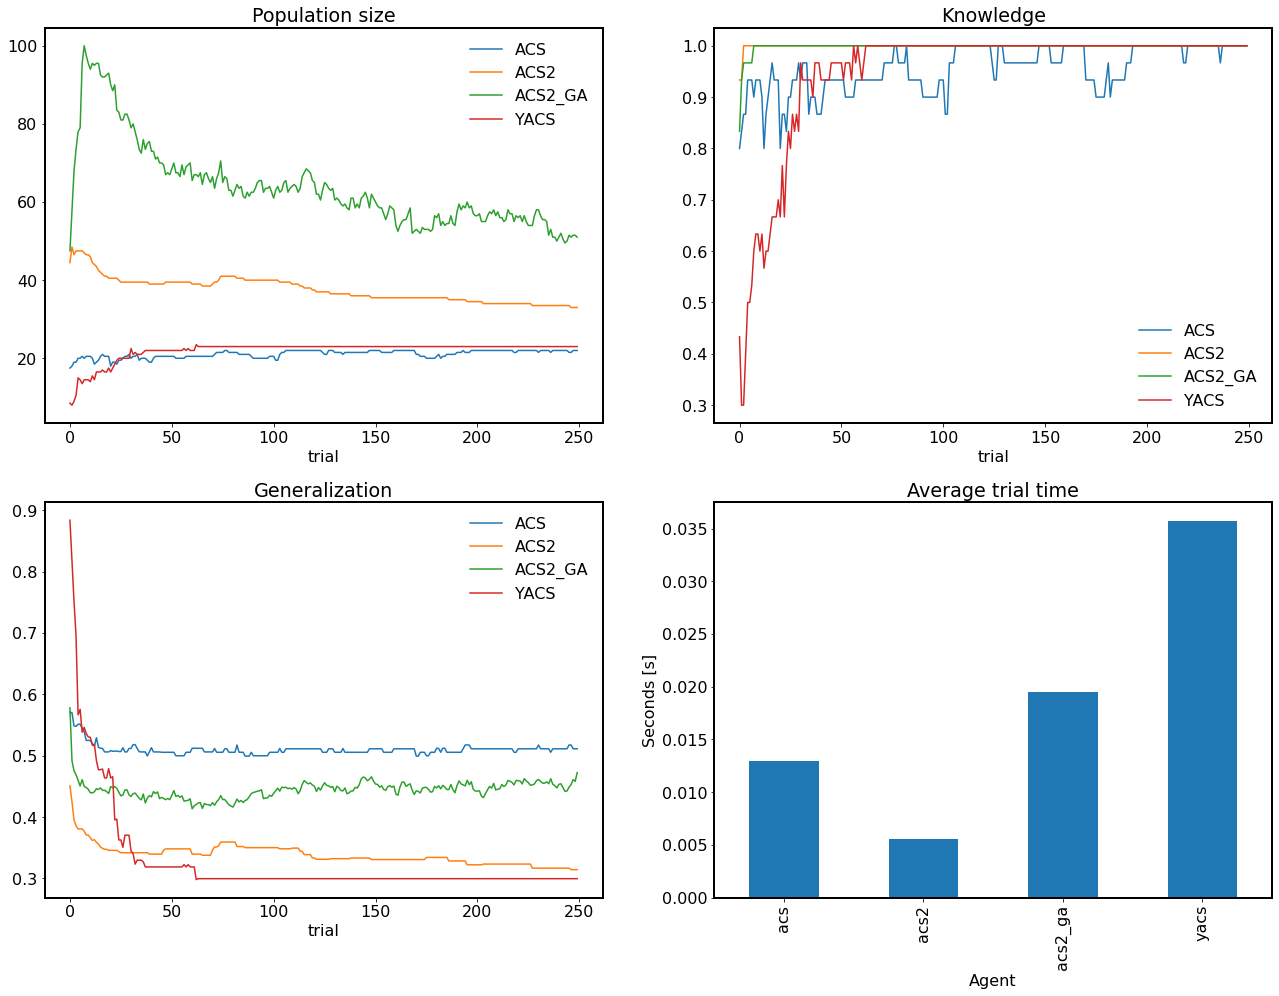

In [12]:
plot_comparison(simple_maze_metrics)
plt.show()

## Corridor

![corridor](img/corridor.png)

In [13]:
import gym_corridor

def corridor_knowledge(pop, env):
    transitions = env.env.get_transitions()
    reliable = [c for c in pop if c.is_reliable()]
    nr_correct = 0

    for start, action, end in transitions:
        p0 = Perception((str(start),))
        p1 = Perception((str(end),))

        if any([True for cl in pop if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / len(transitions)


def corridor_metrics(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': corridor_knowledge(population, env),
        'generalization': generalization_score(population)
    }

class CorridorAdapter(EnvironmentAdapter):
    @staticmethod
    def to_genotype(phenotype):
        return [str(phenotype)]

In [14]:
%%time

common_params = {
    'env': gym.make('corridor-20-v0'),
    'classifier_length': 1,
    'possible_actions': 2,
    'environment_adapter': CorridorAdapter,
    'metrics_trial_freq': 1,
    'metrics_fcn': corridor_metrics,
    'explore_trials': 50
}

yacs_params = {
    'trace_length': 3,
    'feature_possible_values': [19]
}

corridor_metrics = get_from_cache_or_run(
    f'{cache_prefix}/Corridor-metrics.dill', 
    lambda: avg_experiments(lambda: run_experiment(common_params, yacs_params=yacs_params), n=2))

corridor_metrics

CPU times: user 2.23 ms, sys: 0 ns, total: 2.23 ms
Wall time: 1.85 ms


time  knowledge  population  generalization
agent trial                                                 
acs   0      0.009769   0.608108        24.5        0.100000
      1      0.006916   0.635135        25.5        0.091071
      2      0.002142   0.702703        28.0        0.079659
      3      0.002143   0.824324        32.5        0.062741
      4      0.002708   0.851351        33.5        0.060360
...               ...        ...         ...             ...
yacs  45     0.041508   1.000000        38.0        0.000000
      46     0.046381   1.000000        38.0        0.000000
      47     0.080613   1.000000        38.0        0.000000
      48     0.080188   1.000000        38.0        0.000000
      49     0.050831   1.000000        38.0        0.000000

[200 rows x 4 columns]

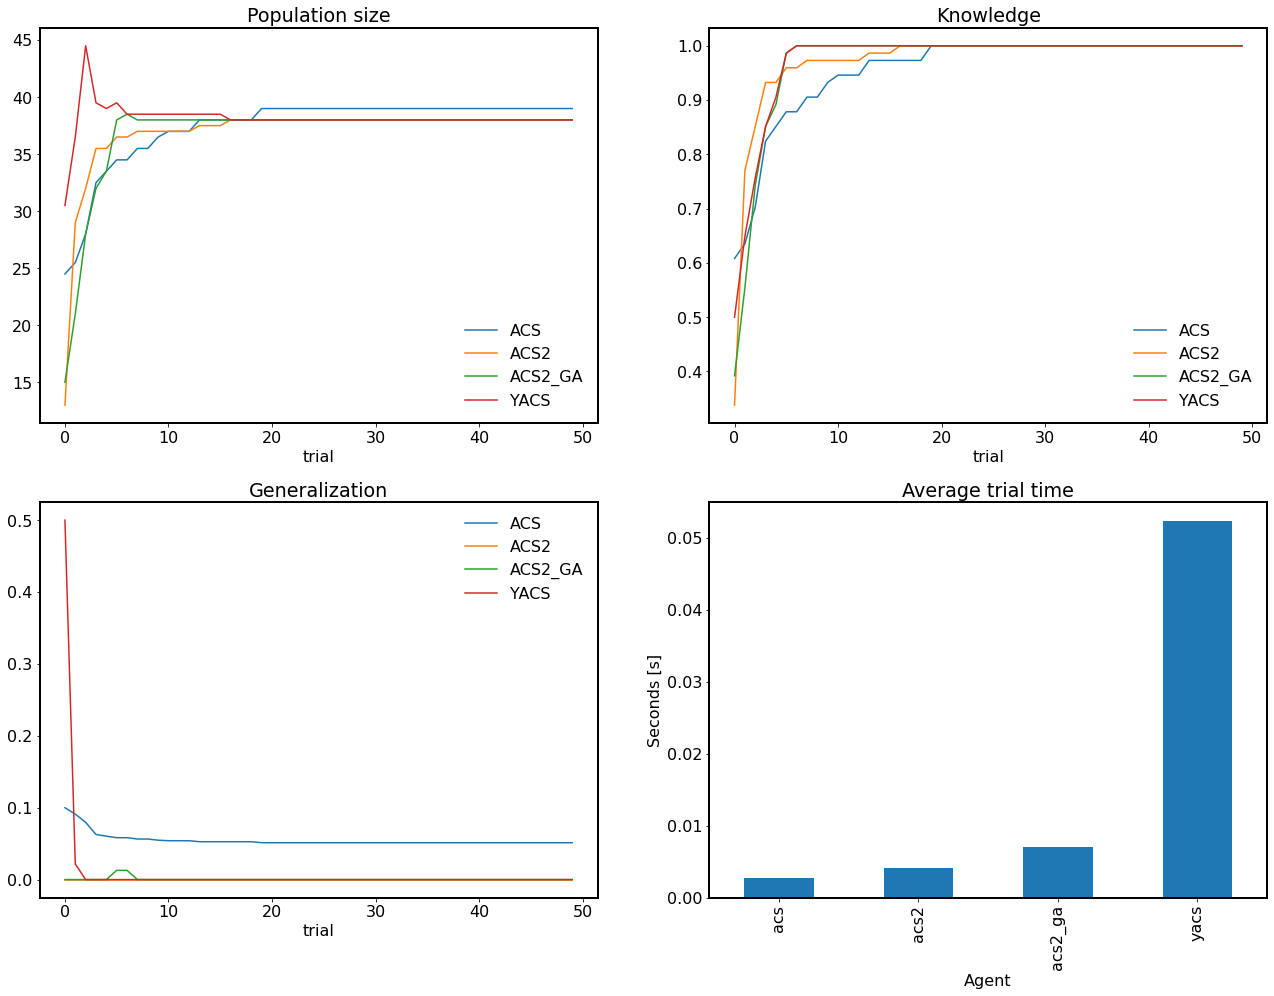

In [15]:
plot_comparison(corridor_metrics)

## Grid
![grid](img/grid.png)

In [16]:
import gym_grid


def grid_knowledge(population, env):
    transitions = env.env.get_transitions()
    reliable = [c for c in population if c.is_reliable()]
    nr_correct = 0
    
    for start, action, end in transitions:
        p0 = Perception([str(el) for el in start])
        p1 = Perception([str(el) for el in end])
        
        if any([True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1
    
    return nr_correct / len(transitions)

def grid_metrics(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': grid_knowledge(population, env),
        'generalization': generalization_score(population)
    }

In [17]:
%%time

common_params = {
    'env': gym.make('grid-20-v0'),
    'classifier_length': 2,
    'possible_actions': 4,
    'environment_adapter': EnvironmentAdapter,
    'metrics_trial_freq': 1,
    'metrics_fcn': grid_metrics,
    'explore_trials': 50
}

yacs_params = {
    'trace_length': 3,
    'feature_possible_values': [20, 20]
}

grid_metrics = get_from_cache_or_run(
    f'{cache_prefix}/Grid-metrics.dill', 
    lambda: avg_experiments(lambda: run_experiment(common_params, yacs_params=yacs_params), n=2))

grid_metrics

CPU times: user 2.89 ms, sys: 496 µs, total: 3.38 ms
Wall time: 2.83 ms


time  knowledge  population  generalization
agent trial                                                 
acs   0      0.314832  12.483531        67.0        0.530092
      1      0.183187  18.412385        72.5        0.527598
      2      0.348146  26.976285        76.5        0.526145
      3      0.243933  34.848485        77.0        0.525974
      4      0.196466  41.403162        77.0        0.525974
...               ...        ...         ...             ...
yacs  45     6.072110  95.685112       446.0        0.263255
      46     5.948170  95.685112       446.0        0.263255
      47     4.495235  95.685112       446.0        0.263255
      48     8.662238  95.685112       446.0        0.263255
      49     8.926037  95.685112       446.0        0.263255

[200 rows x 4 columns]

In [18]:
# grid_metrics.loc['yacs']

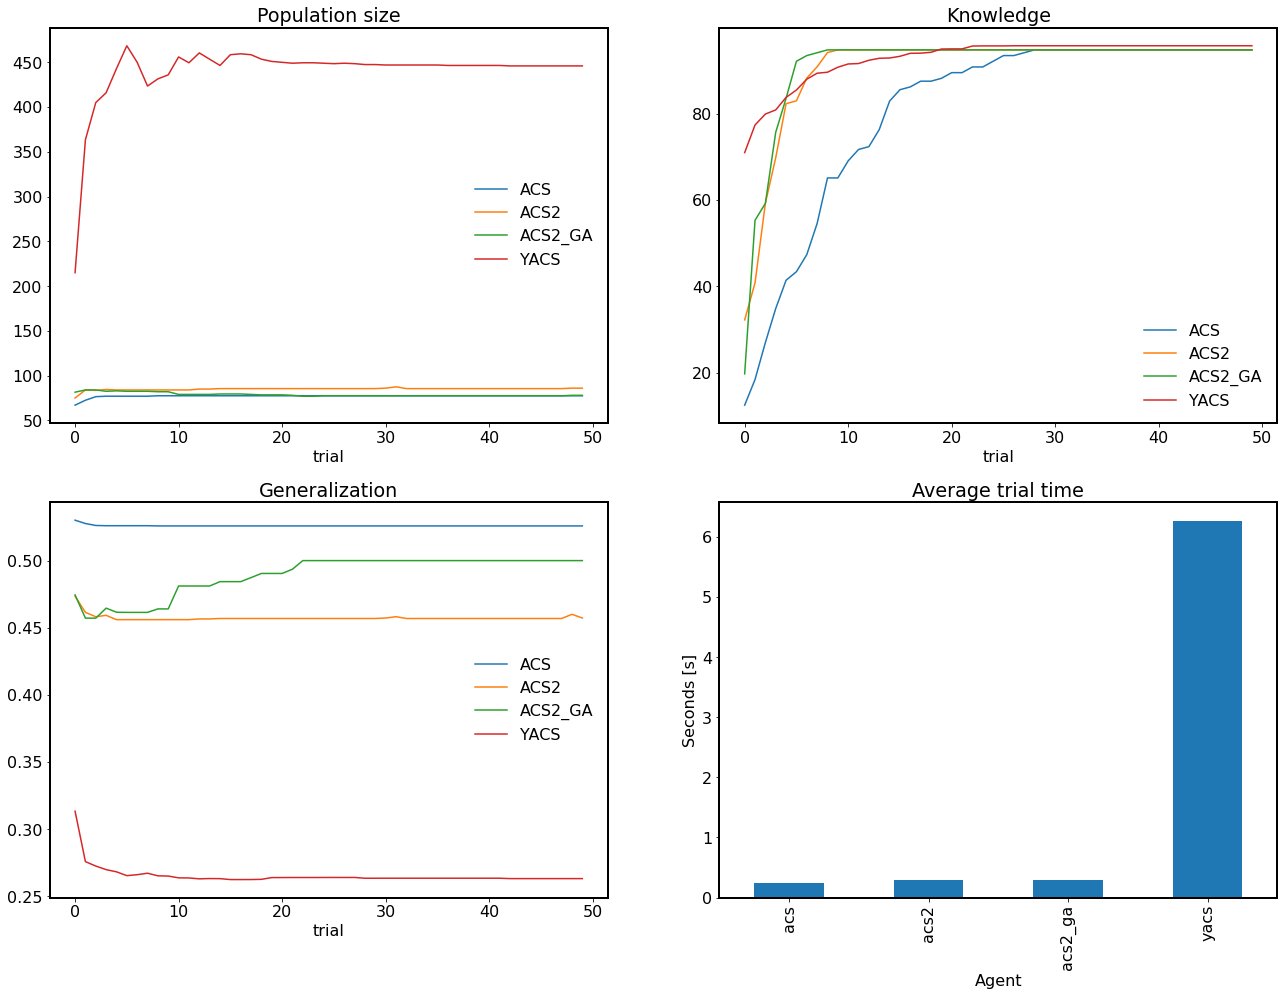

In [19]:
plot_comparison(grid_metrics)

## Conclusions

First obvious points:
- YACS is over-specialising and slow,
- YACS handles big dimensions (Grid environment) poorly